# 2022-09-12 Sparsity and solvers

## Last time

* Advection and boundary layers
* The (cell) Péclet number and oscillations
* Godunov's Theorem

## Today

* Cost of linear solvers
* Assemblying sparse matrices
* Rootfinding and Newton's method for systems

In [3]:
using Plots
default(linewidth=3)
using LinearAlgebra

function vander(x, k=nothing)
    if k === nothing
        k = length(x)
    end
    V = ones(length(x), k)
    for j = 2:k
        V[:, j] = V[:, j-1] .* x
    end
    V
end

function fdstencil(source, target, k)
    "kth derivative stencil from source to target"
    x = source .- target
    V = vander(x)
    rhs = zero(x)'
    rhs[k+1] = factorial(k)
    rhs / V
end

function my_spy(A)
    cmax = norm(vec(A), Inf)
    s = max(1, ceil(120 / size(A, 1)))
    spy(A, marker=(:square, s), c=:diverging_rainbow_bgymr_45_85_c67_n256, clims=(-cmax, cmax))
end

function advdiff_conservative(n, kappa, wind, forcing)
    x = LinRange(-1, 1, n)
    xstag = (x[1:end-1] + x[2:end]) / 2
    L = zeros(n, n)
    rhs = forcing.(x)
    kappa_stag = kappa.(xstag)
    for i in 2:n-1
        flux_L = -kappa_stag[i-1] * fdstencil(x[i-1:i], xstag[i-1], 1) + wind * [.5 .5]
        flux_R = -kappa_stag[i] * fdstencil(x[i:i+1], xstag[i], 1) + wind * [.5 .5]
        js = i-1:i+1
        weights = fdstencil(xstag[i-1:i], x[i], 1)
        L[i, i-1:i+1] = weights[1] * [flux_L..., 0] + weights[2] * [0, flux_R...]
    end
    L[1, 1] = 1
    rhs[1] = 0
    L[2:end, 1] .= 0
    L[end,end] = 1
    rhs[end] = 0
    L[1:end-1,end] .= 0
    x, L, rhs
end

advdiff_conservative (generic function with 1 method)

# Experiments, The (cell) [Péclet number](https://en.wikipedia.org/wiki/P%C3%A9clet_number)

\begin{align}
\big(wu - \kappa u_x\big)_x &= f & \mathrm{Pe}_h &= \frac{h \lvert w \rvert}{\kappa}
\end{align}

minimum(diff(x)) = 0.06896551724137923


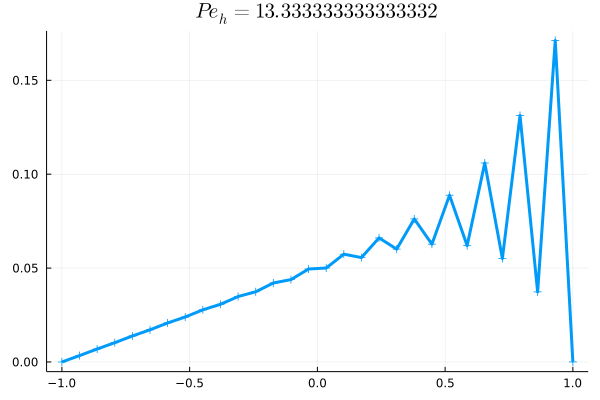

In [44]:
n = 30; h = 2/n
kappa = .1
wind = 20
x, L, rhs = advdiff_conservative(n, x -> kappa, wind, one)
@show minimum(diff(x))
plot(x, L \ rhs, marker=:auto, legend=:none, title="\$Pe_h = $(wind*h/kappa)\$")

In [5]:
function advdiff_upwind(n, kappa, wind, forcing)
    x = LinRange(-1, 1, n)
    xstag = (x[1:end-1] + x[2:end]) / 2
    L = zeros(n, n)
    rhs = forcing.(x)
    kappa_stag = kappa.(xstag)
    for i in 2:n-1
        flux_L = -kappa_stag[i-1] * fdstencil(x[i-1:i], xstag[i-1], 1) +
            wind * (wind > 0 ? [1 0] : [0 1])
        flux_R = -kappa_stag[i] * fdstencil(x[i:i+1], xstag[i], 1) +
            wind * (wind > 0 ? [1 0] : [0 1])
        js = i-1:i+1
        weights = fdstencil(xstag[i-1:i], x[i], 1)
        L[i, i-1:i+1] = weights[1] * [flux_L..., 0] + weights[2] * [0, flux_R...]
    end
    L[1, 1] = 1
    rhs[1] = 0
    L[2:end, 1] .= 0
    L[end,end] = 1
    rhs[end] = 0
    L[1:end-1,end] .= 0
    x, L, rhs
end

advdiff_upwind (generic function with 1 method)

# Upwinded discretization for robustness

Idea: incoming **advective flux** should depend only on upwind value, outgoing should depend only on my value.

minimum(diff(x)) = 0.06896551724137923


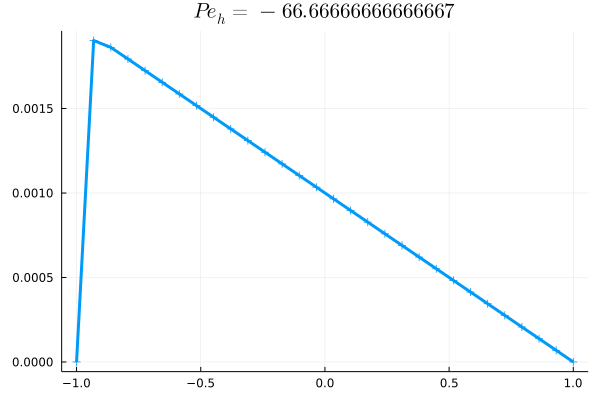

In [46]:
n = 30; h = 2/n
kappa = 1
wind = -1000
x, L, rhs = advdiff_upwind(n, x -> kappa, wind, one)
@show minimum(diff(x))
plot(x, L \ rhs, marker=:auto, legend=:none, title="\$Pe_h = $(wind*h/kappa)\$")

## What is the order of accuracy of the upwinded discretization?

# Godunov's Theorem (1954)

Linear numerical methods
$$ \dot u_i = \sum_j a_{ij} u_j $$
for solving time-dependent PDE can be at most first order accurate if they are monotone.

For our purposes, monotonicity is equivalent to positivity preservation,
$$ \min_x u(0, x) \ge 0 \quad \Longrightarrow \quad \min_x u(t, 0) \ge 0 .$$

## Discontinuities

A numerical method for representing a discontinuous function on a stationary grid can be no better than first order accurate in the $L^1$ norm,
$$ \lVert u - u^* \rVert_{L^1} = \int \lvert u - u^* \rvert . $$
If we merely sample a discontinuous function, say
$$ u(x) = \begin{cases} 0, & x \le a \\ 1, & x > a \end{cases} $$
onto a grid with element size $\Delta x$ then we will have errors of order 1 on an interval proportional to $\Delta x$.

In light of these two observations, we may still ask for numerical methods that are more than first order accurate for smooth solutions, but those methods must be nonlinear.

# How expensive is `\`?

In [7]:

x, L, rhs = advdiff_upwind(5000, x -> kappa, wind, one)
@timev L \ rhs;

  0.563120 seconds (6 allocations: 190.811 MiB, 2.09% gc time)
elapsed time (ns):  563120275
gc time (ns):       11746281
bytes allocated:    200080144
pool allocs:        3
non-pool GC allocs: 0
malloc() calls:     3
free() calls:       7
minor collections:  1
full collections:   0


In [8]:
function elapsed_solve(n)
    x, L, rhs = advdiff_upwind(n, x -> kappa, wind, one)
    @elapsed L \ rhs
end
ns = (1:6) * 1000
times = elapsed_solve.(ns)

6-element Vector{Float64}:
 0.008687873
 0.117921384
 0.132839774
 0.235501316
 0.419815453
 0.665765754

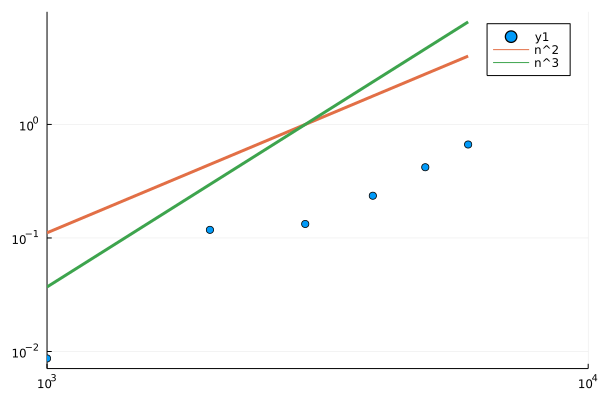

In [11]:
scatter(ns, times, xscale=:log10, yscale=:log10)
plot!(ns, [(ns/3000).^2, (ns/3000).^3], label=["n^2" "n^3"], xrange=(1e3, 1e4))

## How long would $n=10000$ take to solve?

## How much memory would $n=10000$ take?

# Sparsity

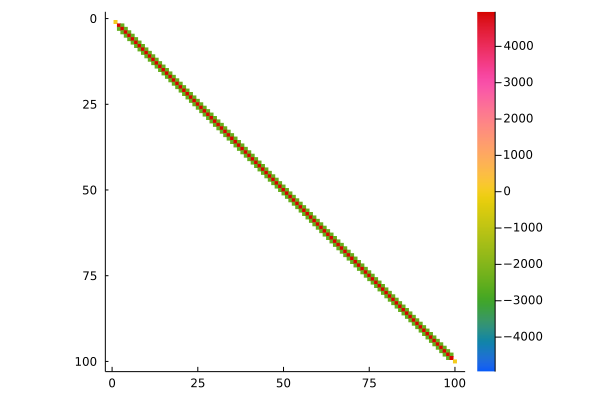

In [47]:
x, L, rhs = advdiff_upwind(100, one, 1, one)
my_spy(L)

In [48]:
using SparseArrays
sparse(L)

100×100 SparseMatrixCSC{Float64, Int64} with 294 stored entries:
⠱⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⢆

# How does solving with the sparse matrix scale?

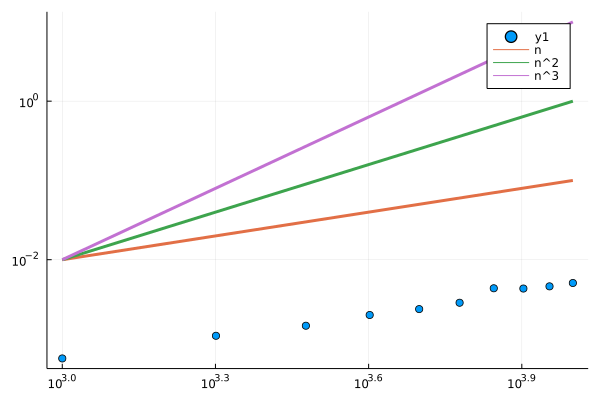

In [18]:
function elapsed_solve(n)
    x, L, rhs = advdiff_upwind(n, x -> kappa, wind, one)
    L = sparse(L)
    @elapsed L \ x
end
ns = (1:10) * 1000
times = elapsed_solve.(ns)
scatter(ns, times, xscale=:log10, yscale=:log10)
plot!([n -> 1e-2*n/1000, n -> 1e-2*(n/1000)^2, n -> 1e-2*(n/1000)^3],
  label=["n" "n^2" "n^3"])

## How much memory is needed?

# [SparseArrays](https://docs.julialang.org/en/v1/stdlib/SparseArrays/) Compressed Sparse Column (CSC)



In [30]:
# starting with a dense matrix
A = sparse([1 0 0 -2; 0 3.14 0 .4; 5.1 0 0 .06])

3×4 SparseMatrixCSC{Float64, Int64} with 6 stored entries:
 1.0   ⋅     ⋅   -2.0
  ⋅   3.14   ⋅    0.4
 5.1   ⋅     ⋅    0.06

In [38]:
@show A.colptr
@show A.rowval
A.nzval

A.colptr = [1, 3, 4, 4, 7]
A.rowval = [1, 3, 2, 1, 2, 3]


6-element Vector{Float64}:
  1.0
  5.1
  3.14
 -2.0
  0.4
  0.06

* CSC (or, more commonly outside Matlab/Julia, row-based CSR) are good for matrix operations (multiplication, solve), but sometimes inconvenient to assemble.

# Matrix assembly using COO format

In [39]:
A

3×4 SparseMatrixCSC{Float64, Int64} with 6 stored entries:
 1.0   ⋅     ⋅   -2.0
  ⋅   3.14   ⋅    0.4
 5.1   ⋅     ⋅    0.06

In [48]:
sparse([1, 1, 2, 2, 3, 3, 1],
       [1, 4, 2, 4, 1, 4, 1],
       [1, -2, 3.14, .4, 5.1, .06, 10])

3×4 SparseMatrixCSC{Float64, Int64} with 6 stored entries:
 11.0   ⋅     ⋅   -2.0
   ⋅   3.14   ⋅    0.4
  5.1   ⋅     ⋅    0.06

# Upwind advection-diffusion solver using COO

In [19]:
function advdiff_sparse(n, kappa, wind, forcing)
    x = LinRange(-1, 1, n)
    xstag = (x[1:end-1] + x[2:end]) / 2
    rhs = forcing.(x)
    kappa_stag = kappa.(xstag)
    rows = [1, n]
    cols = [1, n]
    vals = [1., 1.] # diagonals entries (float)
    rhs[[1,n]] .= 0 # boundary condition
    for i in 2:n-1
        flux_L = -kappa_stag[i-1] * fdstencil(x[i-1:i], xstag[i-1], 1) +
            wind * (wind > 0 ? [1 0] : [0 1])
        flux_R = -kappa_stag[i] * fdstencil(x[i:i+1], xstag[i], 1) +
            wind * (wind > 0 ? [1 0] : [0 1])
        weights = fdstencil(xstag[i-1:i], x[i], 1)
        append!(rows, [i,i,i])
        append!(cols, i-1:i+1)
        append!(vals, weights[1] *  [flux_L..., 0] + weights[2] * [0, flux_R...])
    end
    L = sparse(rows, cols, vals)
    x, L, rhs
end

advdiff_sparse (generic function with 1 method)

# Assembly cost

minimum(diff(x)) = 0.005012531328320691


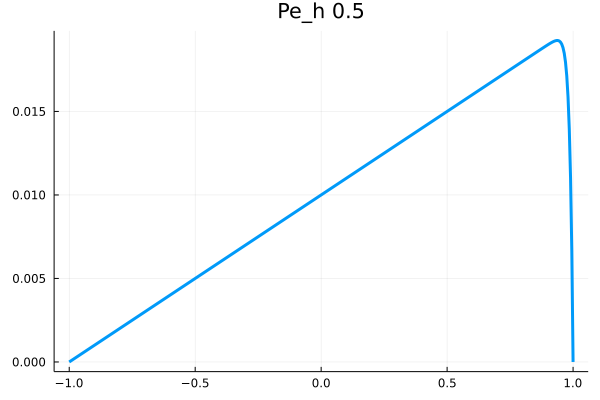

In [51]:
n = 400; h = 2/n
kappa = 1
wind = 100
x, L, rhs = advdiff_sparse(n, x -> kappa, wind, one)
@show minimum(diff(x))
plot(x, L \ rhs, legend=:none, title="Pe_h $(wind*h/kappa)")

In [52]:
n = 10000
@time advdiff_upwind(n, one, 1, one);
@time advdiff_sparse(n, one, 1, one);

  5.870252 seconds (708.47 k allocations: 797.555 MiB, 93.63% gc time)
  0.109083 seconds (698.90 k allocations: 38.447 MiB, 50.08% gc time)


In [23]:
# It's also possible to dynamically insert.
# (But performance this way is generally poor.)
A = spzeros(5, 5)
A[1,1] = 3
A

5×5 SparseMatrixCSC{Float64, Int64} with 1 stored entry:
 3.0   ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅ 

# Nonlinear problems and rootfinding

We want to solve problems like
$$ -(|u_x|^{p-2} u_x)_x + (u^2)_x = 0 $$

For linear problems, we found $u$ such that $L u = b$ using linear algebra.

For nonlinear problems, we'll need to find $u$ such that $F(u) = 0$.

# An algorithm: Bisection

Bisection is a rootfinding technique that starts with an interval $[a,b]$ containing a root and does not require derivatives. Suppose $f$ is continuous. What is a **sufficient** condition for $f$ to have a root on $[a,b]$?

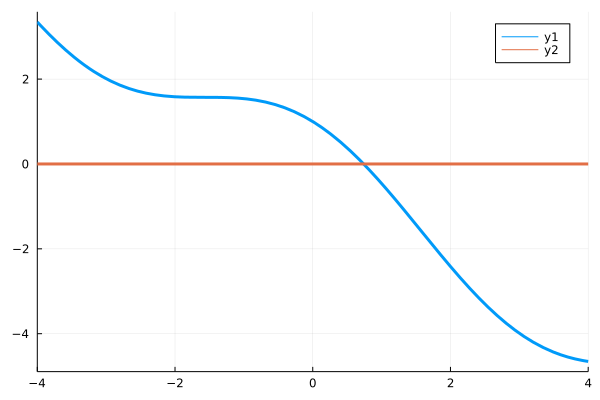

In [24]:
hasroot(f, a, b) = f(a) * f(b) < 0

f(x) =  cos(x) - x
plot([f, x->0], xlims=(-4,4))

In [25]:
hasroot(f, 0, 1)

true

# Bisection

In [26]:
function bisect(f, a, b, tol)
    mid = (a + b) / 2
    if abs(b - a) < tol
        return mid
    elseif hasroot(f, a, mid)
        return bisect(f, a, mid, tol)
    else
        return bisect(f, mid, b, tol)
    end
end

x0 = bisect(f, -1, 3, 1e-5)
x0, f(x0)

(0.7390861511230469, -1.7035832658995886e-6)

# How fast does it converge?

In [27]:
function bisect_hist(f, a, b, tol)
    mid = (a + b) / 2
    if abs(b - a) < tol
        return [mid]
    elseif hasroot(f, a, mid)
        return prepend!(bisect_hist(f, a, mid, tol), [mid])
    else
        return prepend!(bisect_hist(f, mid, b, tol), [mid])
    end
end

bisect_hist (generic function with 1 method)

In [28]:
bisect_hist(f, -1, 3, 1e-4)

17-element Vector{Float64}:
 1.0
 0.0
 0.5
 0.75
 0.625
 0.6875
 0.71875
 0.734375
 0.7421875
 0.73828125
 0.740234375
 0.7392578125
 0.73876953125
 0.739013671875
 0.7391357421875
 0.73907470703125
 0.739105224609375

# Let's plot the error

$$ \lvert \texttt{bisect}^k(f, a, b) - r \rvert, \quad k = 1, 2, \dotsc $$

where $r$ is the true root, $f(r) = 0$.

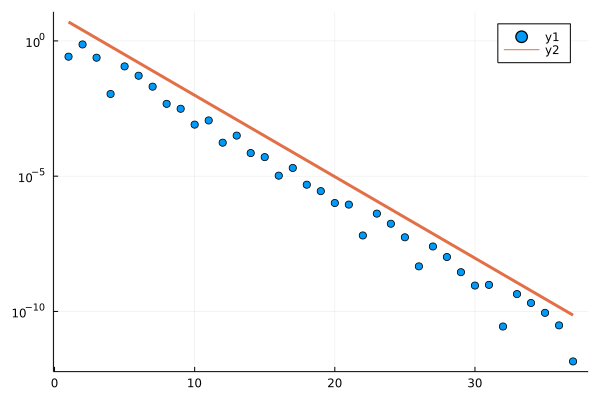

In [29]:
r = bisect(f, -1, 3, 1e-14) # what are we trusting?
hist = bisect_hist(f, -1, 3, 1e-10)
scatter( abs.(hist .- r), yscale=:log10)
ks = 1:length(hist)
plot!(ks, 10 * 0.5 .^ ks)

Evidently the error $e_k = x_k - x_*$ after $k$ bisections satisfies the bound
$$ |e^k| \le c 2^{-k} . $$

# Convergence classes

A convergent rootfinding algorithm produces a sequence of approximations $x_k$ such that $$\lim_{k \to \infty} x_k \to x_*$$ where $f(x_*) = 0$.  For analysis, it is convenient to define the errors $e_k = x_k - x_*$. We say that an iterative algorithm is **$q$-linearly convergent** if $$\lim_{k \to \infty} |e_{k+1}| / |e_k| = \rho < 1.$$  (The $q$ is for "quotient".)  A smaller convergence factor $\rho$ represents faster convergence.  A slightly weaker condition ($r$-linear convergence or just **linear convergence**) is that
$$ |e_k| \le \epsilon_k $$
for all sufficiently large $k$ when the sequence $\{\epsilon_k\}$ converges $q$-linearly to 0.

### Bisection: A = q-linearly convergent, B = r-linearly convergent, C = neither

# Remarks on bisection

* Specifying an interval is often inconvenient
* An interval in which the function changes sign guarantees convergence (robustness)
* No derivative information is required
* Roots of even degree are problematic
* A bound on the solution error is directly available
* The convergence rate is modest -- one iteration per bit of accuracy
* **No good generalization to higher dimensions**

## Newton-Raphson Method

Much of numerical analysis reduces to [Taylor series](https://en.wikipedia.org/wiki/Taylor_series), the approximation
$$ f(x) = f(x_0) + f'(x_0) (x-x_0) + f''(x_0) (x - x_0)^2 / 2 + \underbrace{\dotsb}_{O((x-x_0)^3)} $$
centered on some reference point $x_0$.

In numerical computation, it is exceedingly rare to look beyond the first-order approximation
$$ \tilde f_{x_0}(x) = f(x_0) + f'(x_0)(x - x_0) . $$
Since $\tilde f_{x_0}(x)$ is a linear function, we can explicitly compute the unique solution of $\tilde f_{x_0}(x) = 0$ as
$$ x = x_0 - f(x_0) / f'(x_0) . $$
This is Newton's Method (aka Newton-Raphson or Newton-Raphson-Simpson) for finding the roots of differentiable functions.

# An implementation

In [30]:
function newton(f, fp, x0; tol=1e-8, verbose=false)
    x = x0
    for k in 1:100 # max number of iterations
        fx = f(x)
        fpx = fp(x)
        if verbose
            println("[$k] x=$x  f(x)=$fx  f'(x)=$fpx")
        end
        if abs(fx) < tol
            return x, fx, k
        end
        x = x - fx / fpx
    end  
end
eps = 1e-1
newton(x -> eps*(cos(x) - x), x -> eps*(-sin(x) - 1), 1; tol=1e-15, verbose=true)

[1] x=1  f(x)=-0.04596976941318603  f'(x)=-0.18414709848078967
[2] x=0.7503638678402439  f(x)=-0.0018923073822117442  f'(x)=-0.16819049529414878
[3] x=0.7391128909113617  f(x)=-4.645589899077152e-6  f'(x)=-0.16736325442243014
[4] x=0.739085133385284  f(x)=-2.8472058044570758e-11  f'(x)=-0.16736120293089507
[5] x=0.7390851332151607  f(x)=0.0  f'(x)=-0.1673612029183215


(0.7390851332151607, 0.0, 5)

# That's really fast!

* 10 digits of accuracy in 4 iterations.
* How is this convergence test different from the one we used for bisection?
* How can this break down?

$$ x_{k+1} = x_k - f(x_k)/f'(x_k) $$

In [102]:
newton(x -> cos(x) - x, x -> -sin(x) - 1, .2*pi/2; verbose=true)

[1] x=0.3141592653589793  f(x)=0.6368972509361742  f'(x)=-1.3090169943749475
[2] x=0.8007054703914749  f(x)=-0.10450500785604744  f'(x)=-1.7178474183038182
[3] x=0.7398706100060081  f(x)=-0.0013148113494647617  f'(x)=-1.6741923555416478
[4] x=0.7390852693340639  f(x)=-2.2781024078266654e-7  f'(x)=-1.6736121297866664
[5] x=0.7390851332151648  f(x)=-6.8833827526759706e-15  f'(x)=-1.673612029183218


(0.7390851332151648, -6.8833827526759706e-15, 5)

# Convergence of fixed-point iteration

Consider the iteration
$$x_{k+1} = g(x_k)$$
where $g$ is a continuously differentiable function.
Suppose that there exists a fixed point $x_* = g(x_*)$.  By the [mean value theorem](https://en.wikipedia.org/wiki/Mean_value_theorem), we have that
$$ x_{k+1} - x_* = g(x_k) - g(x_*) = g'(c_k) (x_k - x_*) $$
for some $c_i$ between $x_k$ and $x_*$.

Taking absolute values, $$|e_{k+1}| = |g'(c_k)| |e_k|,$$ which converges to zero if $|g'(c_k)| < 1$.

## Exercise

* Write Newton's method for $f(x) = 0$ from initial guess $x_0$ as a fixed point method.
* Suppose the Newton iterates $x_k$ converge to a simple root $x_*$, $x_k \to x_*$. What is $\lvert g'(x_*) \rvert$ for Newton's method?

# Newton for systems of equations

Let $\mathbf u \in \mathbb R^n$ and consider the function $\mathbf f(\mathbf u) \in \mathbb R^n$. Then
$$ \mathbf f(\mathbf u) = \mathbf f(\mathbf u_0) + \underbrace{\mathbf f'(\mathbf u_0)}_{n\times n} \underbrace{\mathbf \delta u}_{n\times 1} + \frac 1 2 \underbrace{\mathbf f''(\mathbf u_0)}_{n\times n \times n} {(\delta \mathbf u)^2}_{n\times n} + O(|\delta\mathbf u|^3).$$

We drop all but the first two terms and name the Jacobian matrix $J(\mathbf u) = \mathbf f'(\mathbf u)$,
$$ \mathbf f(\mathbf u) \approx \mathbf f(\mathbf u_0) + J \delta \mathbf u .$$
Solving the right hand side equal to zero yields
\begin{align}
J \delta \mathbf u &= -\mathbf f(\mathbf u_k) \\
\mathbf u_{k+1} &= \mathbf u_k + \delta \mathbf u
\end{align}

# Newton in code


In [31]:
function newton(residual, jacobian, u0)
    u = u0
    uhist = [copy(u)]
    normhist = []
    for k in 1:20
        f = residual(u)
        push!(normhist, norm(f))
        J = jacobian(u)
        delta_u = - J \ f
        u += delta_u
        push!(uhist, copy(u))
    end
    uhist, normhist
end

newton (generic function with 1 method)

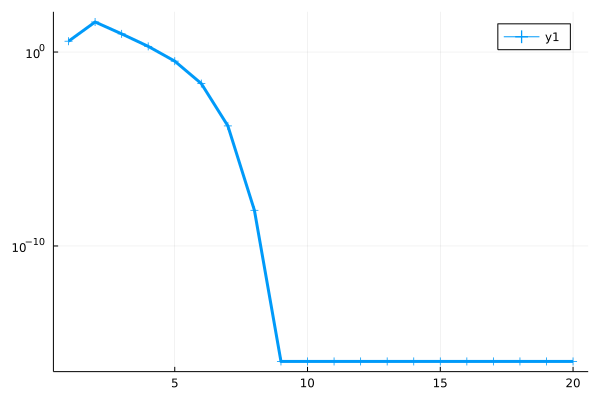

In [32]:
function residual(u)
    x, y = u
    [x^2 + y^2 - 1, x^2 - y]
end
function jacobian(u)
    x, y = u
    [2x 2y; 2x -1]
end

uhist, normhist = newton(residual, jacobian, [0.1, 2])
plot(normhist, marker=:auto, yscale=:log10)

# Plotting the trajectory

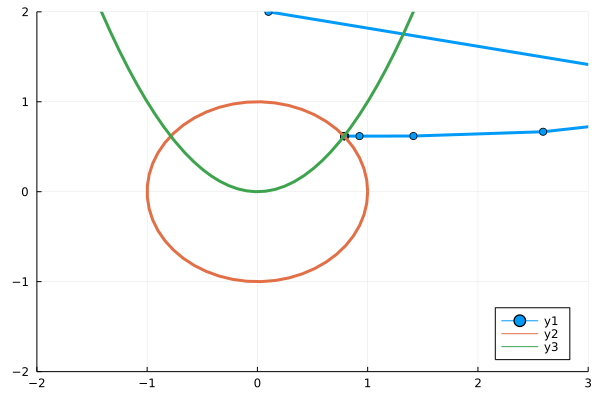

In [34]:
xy = hcat(uhist...)
plot(xy[1,:], xy[2,:], marker=:circle)
circle = exp.(1im*LinRange(0, 2*pi, 50))
plot!(real(circle), imag(circle))
plot!(x -> x^2, xlims=(-2, 3), ylims=(-2, 2), axes=:equal, legend=:bottomright)

# Bratu problem

$$-(u_x)_x - \lambda e^{u}= 0$$

In [35]:
function bratu_f(u; lambda=.5)
    n = length(u)
    h = 2 / (n - 1)
    weights = -fdstencil([-h, 0, h], 0, 2)
    u = copy(u)
    f = copy(u)
    u[1] = 0
    u[n] = 1
    f[n] -= 1
    for i in 2:n-1
        f[i] = weights * u[i-1:i+1] - lambda * exp(u[i])
    end
    f
end

bratu_f (generic function with 1 method)

In [36]:
function bratu_J(u; lambda=.5)
    n = length(u)
    h = 2 / (n - 1)
    weights = -fdstencil([-h, 0, h], 0, 2)
    rows = [1, n]
    cols = [1, n]
    vals = [1., 1.] # diagonals entries (float)
    for i in 2:n-1
        append!(rows, [i,i,i])
        append!(cols, i-1:i+1)
        append!(vals, weights + [0 -lambda*exp(u[i]) 0])
    end
    sparse(rows, cols, vals)
end

bratu_J (generic function with 1 method)

# Solving Bratu

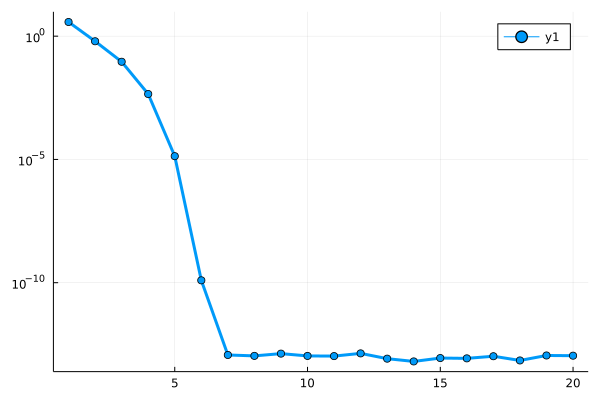

In [40]:
n = 20
x = collect(LinRange(-1., 1, n))
u0 = (1 .+ x) ./ 2
uhist, normhist = newton(bratu_f, bratu_J, u0);

plot(normhist, marker=:circle, yscale=:log10)

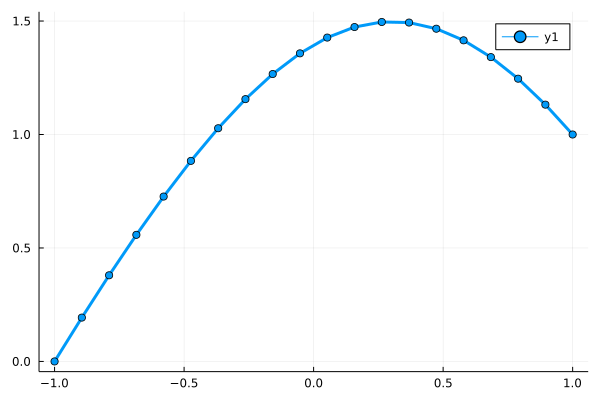

In [41]:
plot(x, uhist[end], marker=:circle)